# LAB 5: Predicting diabetes aplication with decision trees on dataset with missing values

The purpuse of this lab is to use the Pima Indians Diabetes dataset provided in this folder and descibed below, and analyse it to predict diabetes (class attribute) by (a) visualising data;  (b) identifying and handling mising values (values which are abnormal for the data at hand are interpreted as missing values) with imputation (meaning filling in missing values);  (c) training and optimising decision tree predictive models; (d) evaluating the tree models with additional perfomances, other than accuracy; (e) extracting useful rules from the decision tree, and interpreting them.  

## Tasks

1. Study the code with explanations and examples provided in this notebook. Try to understand each cell, run it and check the result. 

2. Build and optimise predictive models based on decision trees (using CV - cross validation on the training set, and a grid  for tuning with all the hyperparameters you learned so far). Use accuracy as main performance measure to optimise the trees: This is scoring='accuracy' in RandomizedSearchCV, and is the default. Plot the best tree. 

3. Manually extract the most useful rules from the tree, and write them down in the form of IF .... THEN class. These are the kind of IF THEN rules seen in the 1st lecture, following paths going from the root to the decision leaves (terminal nodes). A rule is useful if more instances reach the decision leaves. You can extract the most useful 2 rules for each class. Try to interpret what the rules say. Based on the extracted rules, we can see that decision trees are interpretable models, and this constitutes one their advantages. 


## Loading Libraries

In [1]:
# show plots inside the notebook  
%matplotlib inline 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Data Loading

In [2]:
diabetes_dataset = pd.read_csv("diabetes.csv")

Data Set Information:

Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage. 

Attribute Information:

1. Number of times pregnant 
2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test 
3. Diastolic blood pressure (mm Hg) 
4. Triceps skin fold thickness (mm) 
5. 2-Hour serum insulin (mu U/ml) 
6. Body mass index (weight in kg/(height in m)^2) 
7. Diabetes pedigree function 
8. Age (years) 
9. Class variable (0 = no diabetes, and 1 = diabetes) 

The class variable is the outcome variable that is to be predicted.

## Data Checking

In [3]:
diabetes_dataset.shape

(768, 9)

In [4]:
diabetes_dataset.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
diabetes_dataset.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [6]:
diabetes_dataset.groupby("Outcome").size()

Outcome
0    500
1    268
dtype: int64

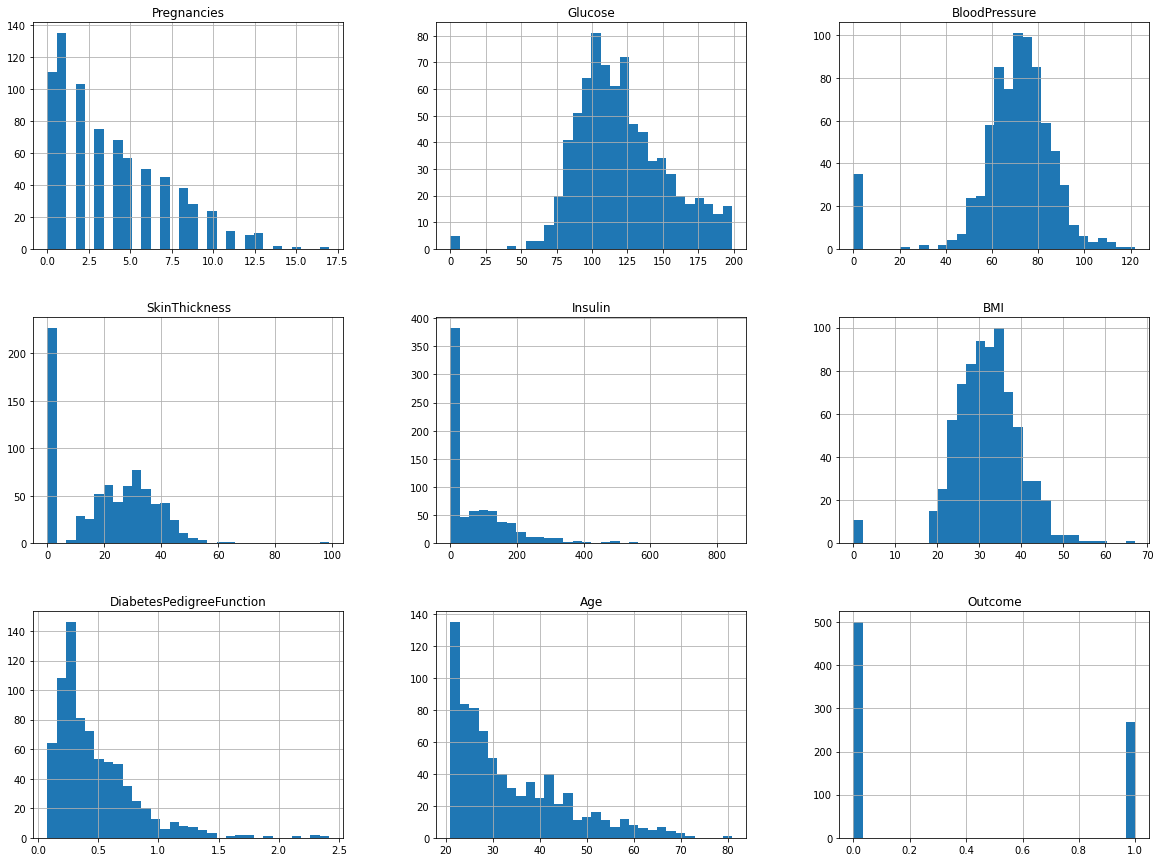

In [7]:
#check variable distributions
diabetes_dataset.hist(bins=30, figsize=(20,15))
plt.show()

Now we know that there are 768 people with an uneven distribution of the outcome (healthy:sick = 500:268). There are also some missing values (0s) for the variables 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin' and 'BMI'.

## Some Data Cleaning

The dataset contains multiple (invalid) zero values. We are going to replace zeros with NAN.

In [8]:
# This replaces zero/invalid values with NANs.
dataset_nozeros = diabetes_dataset.copy()
zero_fields = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI'] 
diabetes_dataset[zero_fields] = diabetes_dataset[zero_fields].replace(0, np.nan)
diabetes_dataset.describe()  # check that there are no invalid values left
diabetes_dataset

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101.0,76.0,48.0,180.0,32.9,0.171,63,0
764,2,122.0,70.0,27.0,NaN,36.8,0.340,27,0
765,5,121.0,72.0,23.0,112.0,26.2,0.245,30,0
766,1,126.0,60.0,NaN,NaN,30.1,0.349,47,1


## Data Stratification

When we split the dataset into train and test datasets, the split is completely random. Thus the instances of each class label or outcome in the train or test datasets is random. Thus we may have many instances of class 1 in training data and less instances of class 2 in the training data. So during classification, we may have accurate predictions for class1 but not for class2. Thus we stratify the data, so that we have proportionate data for all the classes in both the training and testing data.

In [9]:
from sklearn.model_selection import train_test_split 

# divide into training and testing data
train,test = train_test_split(diabetes_dataset, test_size=0.25, random_state=0, stratify=diabetes_dataset['Outcome']) 

# separate the 'Outcome' column from training/testing data
train_X = train[train.columns[:8]]
test_X = test[test.columns[:8]]
train_Y = train['Outcome']
test_Y = test['Outcome']

## Data imputation
We replace NAN with the mean on the column on the training set. Then we uses these means of the training set to impute the test set also. The test set shouldn't be used to infer or transform the training data (this would be data leakage, and may lead in certain situation to biased predictions; the test data should be used only after the model was completeley developped on the train set).

A simple imputation can be done also with the median (replacin mean with median in code below).

In [10]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="mean")
imputer.fit(train_X)
#here are the means per columns that are used for imputation
print('means per columns for imputation', imputer.statistics_)
# now perform the imputation on trainng set
train_X=imputer.transform(train_X)
# and imputation on test set
test_X=imputer.transform(test_X)
print('notice mean values appearing in the train set', train_X)

means per columns for imputation [  3.99652778 121.83187391  72.52631579  29.70959596 155.6959707
  32.31933216   0.47252951  33.71527778]
notice mean values appearing in the train set [[  1.          80.          74.         ...  30.           0.527
   22.        ]
 [  2.         119.          72.52631579 ...  19.6          0.832
   72.        ]
 [ 10.         115.          72.52631579 ...  32.31933216   0.261
   30.        ]
 ...
 [  3.          82.          70.         ...  21.1          0.389
   25.        ]
 [  4.         156.          75.         ...  48.3          0.238
   32.        ]
 [  0.         161.          50.         ...  21.9          0.254
   65.        ]]


# Building and evaluation predictive models on training set, and testing on test set
We'll use cross validation to look also for good values for the model's hyperparameters. We use 5 cross validation. In practice if you have more folds (example 10 in 10CV), you make a better usage of your data, but computation increases, because for each validation fold a model will be fitted on the remaining folds. 10CV implies 10 models. More folds are usualy employed when the dataset is small (to make a better usage of the data). When the dataset is large, fewer folds are fine.     

In [11]:
from sklearn import tree
from sklearn.model_selection import cross_val_score
dt = tree.DecisionTreeClassifier()
scores=cross_val_score(dt, train_X, train_Y, scoring='accuracy', cv=5)
print('acuracy on the 5 folds', scores)
print('and their mean', np.mean(scores))


acuracy on the 5 folds [0.68103448 0.73913043 0.70434783 0.67826087 0.6173913 ]
and their mean 0.6840329835082459


In [12]:
# in the previous construction of the decision tree, the hyperparameters (such as depth, split criterion, etc) were default values
# lets try other values, for instance 3 levels:
dt.max_depth=3
scores=cross_val_score(dt, train_X, train_Y, scoring='accuracy', cv=5)
print('acuracy on the 5 folds of CV', scores)
print('and their mean', np.mean(scores)) # we see performance improved

acuracy on the 5 folds of CV [0.73275862 0.72173913 0.71304348 0.69565217 0.73043478]
and their mean 0.7187256371814092


In [13]:
# try other values for hyperparameters and see which ones give you a higher accuracy
dt.max_depth=5
scores=cross_val_score(dt, train_X, train_Y, scoring='accuracy', cv=5)
print('acuracy on the 5 folds of CV', scores)
print('and their mean', np.mean(scores)) 


acuracy on the 5 folds of CV [0.73275862 0.70434783 0.71304348 0.73913043 0.70434783]
and their mean 0.7187256371814092


In [14]:
# try other values for hyperparameters 
dt.max_depth=5
dt.criterion='entropy'  # by default the criterion for split is gini impurity; we change it to entropy
min_samples_split=10 # by default this is 2 - look into the decision tree sklearn doc https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
scores=cross_val_score(dt, train_X, train_Y, scoring='accuracy', cv=5)
print('acuracy on the 5 folds of CV', scores)
print('and their mean', np.mean(scores))

acuracy on the 5 folds of CV [0.69827586 0.75652174 0.77391304 0.72173913 0.68695652]
and their mean 0.7274812593703148


In [15]:
# and let's do this also automatically by fine tuning the model using searches on grids with the values of the hyperparameters

from sklearn.model_selection import GridSearchCV

# here's the grid on 1 hyperparamer, max_depth. You can have more hyperparameters, and a model will be buit for each combination of values of hyperparameters.

param_grid = [
     {'max_depth': [2, 3, 4, 5, 6, 7, 8]} ]

grid_search = GridSearchCV(dt, param_grid, cv=5,
                           scoring='accuracy',
                           return_train_score=True)

grid_search.fit(train_X, train_Y)
print('best parameter values', grid_search.best_params_)
print('best estimator', grid_search.best_estimator_)

best parameter values {'max_depth': 5}
best estimator DecisionTreeClassifier(criterion='entropy', max_depth=5)


In [16]:
# display performances per each repetition of cross validation
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.mean(mean_score), params)

# We can see the best accuracy 0.75 is reached for 4 levels in the decision tree. You can do also a plot here to see how performance varies.


0.7014542728635682 {'max_depth': 2}
0.7187256371814092 {'max_depth': 3}
0.7117991004497751 {'max_depth': 4}
0.7222788605697151 {'max_depth': 5}
0.7083808095952022 {'max_depth': 6}
0.7066566716641678 {'max_depth': 7}
0.6944527736131934 {'max_depth': 8}


In [17]:
# Now we evaluate the best model on the test set, to compute accuracy, precision, recall and F1 score.
# In many applications accuracy is good, but in some cases, if we use it alone, is not suffiecient 
# to judge the performance of a model, in particular when we want a good detection of the class of interest/ positive/ 
# yes class (here diabetes).
# Recall (also called sensitivity, or true positive rate) is a suitable performance score to look at, and this is 
# defined as the detection rate of the positive class, or in this context, the percentage of correctly classified diabetes 
# patients out of those who have diabetes.
# Another useful performance score is the Precision, and this is the ratio of true positives out of those which 
# were predicted as positives.
# In other words, in our application, Precision is the percentage of those who have diabetes out 
# of those predicted by the (imperfect) model to have diabetes.
# The harmonic mean of the Precuson and Recall is the F1 performance measure. It reaches a larger value only if 
# both Precision and Recall are larger. Otherwise it advantages the smaller value of the two performances. 

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

best_dt=grid_search.best_estimator_
pred_Y=best_dt.predict(test_X)

print('\n accuracy', accuracy_score(test_Y, pred_Y))
print('\n precision', precision_score(test_Y, pred_Y))
print('\n recall (sensitivity)', recall_score(test_Y, pred_Y))
print('\n f1', f1_score(test_Y, pred_Y))



 accuracy 0.734375

 precision 0.625

 recall (sensitivity) 0.5970149253731343

 f1 0.6106870229007634
